# Finding *Stories* in the New York Times' Data

### Motivation

The NYT archive contains a few millions of documents including articles, videos, blogs etc. Naturally, a collection of documents can be interpreted as a *story*, which means a sequence of publications in a time frame that shares the same subject and draws to the reader some logical story.  

We would like to automatically detect stories over 30 year of data, visualize it interactively in a time-line so we could explore conveniently over stories and try to find some non obvious stories.

Here is an example of a (sad) story, which was found by our analysis. It is a sequence of publication of deaths in Iraq from 2003 - 2012.

In [13]:
from IPython.display import HTML
HTML(filename='killed_in_iraq.html')


### The Method

As long as finding stories may be difficult problem even on the semantic level, we simplified it with a very naive assumption: documents that belongs to same story have similar title or lead paragraph. 

The task was divided into 4 sections: 

1. Finding <u>pairs of similar documents</u> that can be considered as good candidates. 
2. <u>Finding community</u> of documents that are similar to each other.
3. Visualize it.
4. Randomly sample generated stories and manually evaluate if they are indeed stories according to the definition.

### Similar items using minhash and LSH

Each document has represented by it's title and lead paragraph (just as a long sentence), and we applied the <u>similar items algorithm</u> with **a modification**: the sentences themselves were minhashed (by endocing the text to utf8) instead their shingle index.

Why is that? the whole data's weight is 1.83 GB of 2131065 documents, what caused the main memory to overload very quickly if we tried to process the data in one piece. So for minhashing we partitioned the processing to pieces by **years of publication**, and saves everything in pickles files. All in all the process took ~1 hour of running time. Now, let's say that first we would shingles to 4-grams and only then do the minhashing, as we taught in class, then when we would like to evaluate performance for 5-grams for example, we would need to minhash again which means one more hour of processing time. 

So by minhashing the sentences themselves we gain minhashing the whole data only once for all the analysis.

#### Parameters choosing - n-grams, k (permutations), # bands. 

We choose parameters by evaluating results from data of one year, 2018, then perform stories generation to all of the data.

As for **number of permutations k**, we started with k=100. We took pair of similar sentences and saw that changing to k=1000 reduce the variance of Jaccard estimation only in a negligible value, so we stay with **k=100**.  

As for n-gram, because of the fact that we evaluate results manually by observing the generated stories, we couldn't perform kind of model selection for choosing ideal n-grams, but only to evaluate it by feeling. We tried n-grams of words and characters with n=2, 3, 4. Finally, **4-grams of characters** was produces satisfied results. 

As for number of bands, since we have k=100 we tried 5 different probabilities model characteristics as follows:

![Jaccard Similarity](https://drive.google.com/uc?export=view&id=1J2s1NXMUUFwPbxoPw5CEjkTtOgiumJ6f)

We bear in mind the documents of a story may not be that similar, but with some differences, so we wanted out model to be relaxed. We choose **# bands=20** (the red line).

The process ended up with a list of 21993216 (22e6 comparison instead of 4e12 !) candidate pairs. Since we didn't want pairs with Jaccard of 1, which mean equal documents (although we drop duplicates), we passed pairs with **0.7 <= Jaccard <= 0.9**.

### Find Communities

We defined a weighted graph in which each edge is a candidates and the weight is Jaccard similarity. We use the `community` python library and performed Louvain algorithm to find best partition, i.e the highest partition of the dendrogram.

### Results

At the first round we generated stories from ALL of the data, without any filtering. The results were quiet the mess! Here are 40 out of 2964 stories that were found. 
The results clearly demonstrates the mistaken assumption we took. In the NYT, lots of weekely columns shares the same title or lead paragraph, without represent a true story of something. For example see stories (1) Word + Quiz, (3) Your Tuesday Briefing, (11) 5 Comedy Shows to Catch in NYC This Weekend. (19) 9 New Books We Recommend This Week etc, etc.. there are hundreds of more.

In [10]:
HTML(filename='bad.html')

With that in mind, we've tried to filter the stories generation only for the most "storyable" topics - pilitics and the world. Here are the results. 
Story (5) and (6) are reviewies of election results US coutries and India respectively. Story (3) is a review of the situation in the middle east during 2006-2008. Take a look at story (13) - Mexico City has created "Women Only" buses in response to complaints of sexual harassment on public transportation. This story has reviewed over 3 days in February. 

In [22]:
HTML(filename='stories_0.html')

## This is the code with which we generated stories from ALL of the data without any filtering. Generate stories per new section has done as well, see appendices.

In [0]:
import itertools
from lsh import minhash  # https://github.com/mattilyra/lsh
import datetime
from api_client import APIclient
import pandas as pd
import community
import networkx as nx
import numpy as np
from collections import defaultdict
import pickle

In [0]:
char_ngram = 4
bands = 20
seeds = 100
jaccard_min = 0.7
jaccard_max = 0.95
start_year = 1999
end_year = 2020
api_client = APIclient()

hasher = minhash.MinHasher(seeds=seeds, char_ngram=char_ngram, hashbytes=4)

def generate_shingles(text):
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram))

def jaccard(set_a, set_b):
    intersection = set_a & set_b
    union = set_a | set_b
    return len(intersection) / len(union)

def clean_text(df):
    df['text'] = df['headline'].astype(str) + ' ' + df['snippet'].astype(str)
    df['text'] = df['text'].apply(lambda x: x.encode('utf8'))
    df = df[['_id', 'text']]
    df = df.set_index('_id')
    return df

## Get data from Mongo, generate fingerprint
Note: This snnipet won't work unless a Mongo Deamon is running with right credentials.

In [0]:
for year in range(start_year, end_year):
    res = api_client.aggregate(
            [
                {'$match': {'pub_date': {'$lte': datetime.datetime(year, 12, 31),
                                         '$gte': datetime.datetime(year, 1, 1)}}},
                {
                    '$project':
                        {
                            'headline': '$headline.main',
                            'snippet': '$snippet',
                            # 'by': {'$substr': ['$byline.original', 3, -1]},
                        }
                }
            ]
    )
    df = pd.DataFrame(list(res)).dropna()
    df = clean_text(df)

    df['fingerprint'] = df['text'].apply(lambda t: hasher.fingerprint(t))
    df['fingerprint'].to_pickle('fingerprint/{}.pkl'.format(year))

## Hash to buckets

In [0]:
bins = [defaultdict(set) for _ in range(bands)]

def bins_gen(fingerprint):
    yield from enumerate(np.array_split(fingerprint, bands))

def add_fingerprint(fingerprint, doc_id):
    for bin_i, bucket in bins_gen(fingerprint):
        bucket_id = hash(tuple(bucket))
        bins[bin_i][bucket_id].add(doc_id)

In [0]:
for year in range(start_year, end_year):
    df = pd.read_pickle('fingerprint/{}.pkl'.format(year))
    for i in range(len(df)):
        add_fingerprint(df.iloc[i], doc_id=df.index.values[i])
    with open('bins/{}.pkl'.format(year), 'wb') as f:
        pickle.dump(bins, f)
    
    del df
    del bins
    bins = [defaultdict(set) for _ in range(bands)]

## Find candidate pairs

In [0]:
for bin_i in range(bands):
    b = defaultdict(set)
    for year in range(start_year, end_year):
        with open('bins/{}.pkl'.format(year), 'rb') as f:
            bins = pickle.load(f)[bin_i]   
            for bucket_id in bins:
                b[bucket_id].update(bins[bucket_id])
            del bins
    print(bin_i)
    with open('bins/bin_{}.pkl'.format(bin_i), 'wb') as f:
        pickle.dump(b, f)

In [0]:
candidate_pairs = set()
for bin_i in range(bands):
    with open('bins/bin_{}.pkl'.format(bin_i), 'rb') as f:
        b = pickle.load(f) 
        for bucket_id in b:
            if len(b[bucket_id]) > 1:
                pairs = set(itertools.combinations(b[bucket_id], r=2))
                candidate_pairs.update(pairs)
        del b
    print(bin_i)
with open('candidate_pairs.pkl', 'wb') as f:
        pickle.dump(candidate_pairs, f)

## Compute Jaccard sim. Find communities

In [0]:
def get_text_by_id(id):
    res = api_client.aggregate(
            [
                {'$match': {'_id': id}},
                {'$project': {'headline': '$headline.main', 'snippet': '$snippet'}}
            ]
        )
    return clean_text(pd.DataFrame(list(res)))

In [0]:
with open('candidate_pairs.pkl', 'rb') as f:
        candidate_pairs = pickle.load(f)
G = nx.Graph()
for docid_a, docid_b in candidate_pairs: 
    shingles_a = generate_shingles(get_text_by_id(docid_a).iloc[0]['text'])
    shingles_b = generate_shingles(get_text_by_id(docid_b).iloc[0]['text'])
    jaccard_sim = jaccard(shingles_a, shingles_b)
    if jaccard_min <= jaccard_sim <= jaccard_max:
        G.add_edge(docid_a, docid_b, weight=jaccard_sim)

print('{} of actual pairs were found'.format(nx.number_of_edges(G)))

partition = community.best_partition(G)
comm = []
for com in set(partition.values()):
    comm.append([nodes for nodes in partition.keys() if partition[nodes] == com])

## Get full data of stories and export visualization .html files

In [0]:
stories = []
for c in comm:
    res = api_client.aggregate(
        [
            {'$match': {'_id': {'$in': c}}},
            {
                '$project':
                    {
                        'pub_date': '$pub_date',
                        'headline': '$headline.main',
                        'url': '$web_url',
                    }
            },
            {'$sort': {'pub_date': 1}}
        ]
    )
    story = pd.DataFrame(list(res))

    # if story has lasted less then 1 day, it isn't a story
    if (story.iloc[-1]['pub_date'] - story.iloc[0]['pub_date']).days > 1:
        stories.append(story)

In [0]:
from bokeh.models import ColumnDataSource, TapTool, OpenURL
from bokeh.layouts import gridplot
from bokeh.plotting import figure, save, output_file

In [0]:
stories_in_page = 40
files_count = 0

print('{} stories were found'.format(len(stories)))


def save_stories(grid):
    global files_count
    output_file('stories_{}.html'.format(files_count))
    files_count += 1
    save(gridplot(grid))


TOOLTIPS = """
    <div id="Tooltip">
        <div>
            <span style="font-size: 16px; font-weight: bold;">@headline</span>
        </div>
        <div>
            <span style="font-size: 10px;">Click to the article!</span>
        </div>
    </div>
"""
grid = []
for i, story in enumerate(stories):
    if i and not i % stories_in_page:
        save_stories(grid)
        grid = []
    story['y'] = 1
    p = figure(plot_height=100, plot_width=1200, title=story.iloc[0]['headline'],
               x_axis_type='datetime', tools='tap', tooltips=TOOLTIPS)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.yaxis.visible = False
    source = ColumnDataSource(story)
    p.square('pub_date', 'y', size=10, source=source, fill_alpha=0.5)
    url = '@url'
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)
    grid.append([p])

save_stories(grid)

# Appendix 1 - Generate stories in the field of politics and the world (more storyable topics)

In [0]:
# change get query to:
res = api_client.aggregate(
            [
                {
                    '$match': {
                        'pub_date': {'$lte': datetime.datetime(end_year, 12, 31),
                                         '$gte': datetime.datetime(start_year, 1, 1)},
                        'section_name': {'$in': ['Elections', 'Politics', 'Tracking Trumps Agenda', 'The Upshot', 'Opinion | Politics', 'Upshot',
                                                'Washington '] +
                                                ['World', 'Africa', 'Americas', 'Asia', 'Asia Pacific', 'Australia',
                                                 'Canada', 'Europe', 'Middle East',
                                                 'What in the World', 'Opinion | The World', 'Foreign']
                                         }
                    }
                },
                {
                    '$project':
                        {
                            'headline': '$headline.main',
                            'snippet': '$snippet',
                        }
                }
            ]
        )

# Appendix 2- plot the number of bands selection analysis 

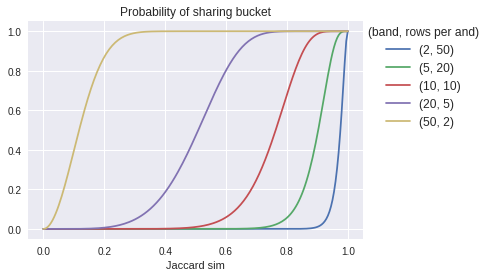

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
ix = pd.IndexSlice


df = pd.DataFrame(data=[(2, 50), (50, 2), (10, 10), (5, 20), (20, 5)], columns=['b', 'r'])
df['hashes'] = df['b'] * df['r']
for pr in np.linspace(0, 1, 200):
    df[pr] = 1 - (1 - pr**df['r']) ** df['b']

df = pd.pivot_table(df, index=['hashes', 'b', 'r'])

ax = df.T.plot(figsize=(6, 4), title='Probability of sharing bucket')
plt.xlabel('Jaccard sim')
plt.legend(list(df.loc[ix[100]].index), bbox_to_anchor=(1., 1, 1., 0), loc='upper left', fontsize=12, ncol=1, borderaxespad=0., title='(band, rows per and)')